In [1]:
# Set up a virtual display for rendering OpenAI gym environments.
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [2]:
# General dependencies
import numpy as np

# Dependencies for generating mp4 file
import imageio
import IPython
import base64

# Custom Dependencies
from lib.agent import dql
from lib.env import FrozenLakeEnv

2023-02-16 10:07:30.231000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 10:07:30.609851: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/lib/
2023-02-16 10:07:30.609895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/lib/
2023-02-16 10:07:30.609900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

# Generate Environment

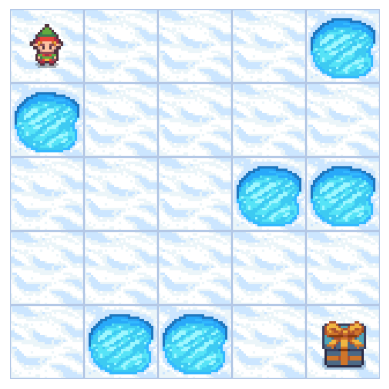

In [3]:
numOfMaze = 1
maze_dim = 5
envList = [FrozenLakeEnv(maze_dim, frozen_prob=0.8) for i in range(numOfMaze)]
ENV = envList[0]
ENV.display_map()

# Define Hyparameters

In [4]:
# Learning Rate
alpha = 1e-3 

# Discount Factor
gamma = 0.875 

# Epsilon
epsilon = 0.5

# Epsilon decay rate
tau = 0

# Total episode
E = 100

# Maximum timestep
T = 30

# Target network copy interval
C = 5

# Replay memory depth
D = 1500

# Batch size
X = 5

# Initialize Agent 

In [5]:
DQL = dql(
        environment=ENV.env,
        learning_rate=alpha,
        discount_factor=gamma,
        epsilon=epsilon,
        eps_decay_rate=tau,
        eps_min_val=0.25,
        total_episode=E,
        maximum_timestep=T,
        copy_target_interval=C,
        experience_memory_size=D,
        batch_size=X)

2023-02-16 10:07:31.540772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 10:07:31.839540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22198 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:2d:00.0, compute capability: 8.6


In [6]:
DQL.learn()

Model: "Q-Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 25)]              0         
                                                                 
 Hidden (Dense)              (None, 20)                520       
                                                                 
 Output (Dense)              (None, 4)                 84        
                                                                 
Total params: 604
Trainable params: 604
Non-trainable params: 0
_________________________________________________________________
Model: "T-Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 25)]              0         
                                                                 
 Hidden (Dense)              (None, 20) 

2023-02-16 10:07:32.610584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-16 10:07:32.938595: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1bab58d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-16 10:07:32.938625: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-02-16 10:07:32.942329: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-16 10:07:32.997161: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-16 10:07:33.027587: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most onc

...................................
Episode 10 [64.25984644889832s]...................................
Episode 20 [124.95330667495728s]....................
Episode 30 [154.06676054000854s]............................
Episode 40 [202.36255407333374s]...................
Episode 50 [227.44816517829895s].....................
Episode 60 [256.65882778167725s]......................
Episode 70 [290.02932691574097s]......................
Episode 80 [322.57334208488464s]....................
Episode 90 [351.3944182395935s].....................
Execution time = 383.35760736465454s


In [7]:
DQL.QNetwork.name

'Q-Network'

In [8]:
DQL.show_network_arch()

In [9]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

In [10]:
def create_video2(network, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = ENV.env.reset()
            video.append_data(ENV.env.render())
            while not time_step.is_last():
                st = time_step.observation
                Q_values = DQL.get_q(st, network)
                at = np.argmax(Q_values)
                time_step = ENV.env.step(at)
                video.append_data(ENV.env.render())
    return embed_mp4(filename)

In [11]:
create_video2(DQL.QNetwork, 'test', num_episodes=1, fps=10)

In [12]:
DQL.epsilon_history

[0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5]

In [13]:
len(DQL.epsilon_history)

100